In [2]:
from unittest.mock import inplace

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plots.utils.open_llm_leaderboard import get_openllm_leaderboard_data, clean_text, extract_model_info
from plots.utils.plotting import write_figure_to_disk

# Introductory Plot: LLM Zoo & Performance

In [3]:
leaderboard_data = get_openllm_leaderboard_data()
leaderboard_data = leaderboard_data.loc[leaderboard_data["Flagged"] == False]
leaderboard_data = leaderboard_data.loc[leaderboard_data["Official Providers"] == True]
leaderboard_data = leaderboard_data.loc[leaderboard_data["Merged"] == False]
leaderboard_data = leaderboard_data.loc[leaderboard_data["Generation"] > 0]

leaderboard_data["param_count_num"] = leaderboard_data["#Params (B)"] * 1_000_000_000


In [4]:
# print(leaderboard_data.columns)

model_vendors_of_interest = ["meta-llama", "Qwen", "google", "microsoft", "ibm-granite"]  # "mistralai",
leaderboard_data["Model"] = leaderboard_data["Model"].apply(clean_text)
relevant_model_arch = leaderboard_data["Model"].unique()

patterns = []
for vendor in model_vendors_of_interest:
    # Match the vendor name when it's at the start of the string or after a "/"
    patterns.append(f"(^|/){vendor}")

pattern = '|'.join(patterns)
leaderboard_data = leaderboard_data[leaderboard_data["Model"].str.contains(pattern, case=False)]
leaderboard_data = leaderboard_data[leaderboard_data["Base Model"].str.contains(pattern, case=False)]

leaderboard_data[["Vendor", "Model Family", "Version", "param_count", "Purpose"]] = leaderboard_data["Model"].apply(extract_model_info)
leaderboard_data = leaderboard_data.loc[leaderboard_data["Vendor"] != "mlabonne"]


# Rename
leaderboard_data["Vendor"] = leaderboard_data["Vendor"].replace({
    "Qwen": "Qwen",
    "meta-llama": "Meta",
    "nvidia": "NVIDIA",
    "google": "Google",
    "mistralai": "MistralAI",
    "ibm-granite": "IBM",
})

# Fine Filter model families
model_families_of_interest = ['Qwen', 'Llama-', 'gemma-', 'granite-', 'Mistral-']
model_pattern = '|'.join(model_families_of_interest)
leaderboard_data = leaderboard_data[
    (leaderboard_data["Model Family"].str.contains(model_pattern, case=False)) &
    ~(leaderboard_data["Model Family"].str.contains("Meta-Llama-", case=False)) &
    ~(leaderboard_data["Model Family"].str.contains("Mistral-Nemo-Instruct-", case=False)) &
    ~(leaderboard_data["Model Family"].str.contains("Mixtral-", case=False))
]

# Rename model families
leaderboard_data["Model Family"] = leaderboard_data["Model Family"].replace({
    "Qwen": "Qwen",
    "Llama-": "Llama",
    "gemma-": "Gemma",
    "Mixtral-": "Mixtral",
    "granite-": "Granite",
    "Mistral-": "Mistral"
})

def make_family_name(row):
    return row["Vendor"] + "/" + row["Model Family"] + "-" + row["Version"]

def make_model_name(row):

    if row["Model Family"] == "Mistral" or row["Model Family"] == "Mixtral":
        name = row["Vendor"] + "/" + row["Model Family"] + " (" + row["param_count"].upper() + ")"
    else:
        name = row["Vendor"] + "/" + row["Model Family"] + "-" + row["Version"] + " (" + row["param_count"].upper() + ")"

    return name

leaderboard_data["model_name"] = leaderboard_data.apply(make_model_name, axis=1)
leaderboard_data["family_name"] = leaderboard_data.apply(make_family_name, axis=1)

leaderboard_data = leaderboard_data.sort_values(
    by=["Vendor", "family_name", "#Params (B)"],
    ascending=[True, False, True]
)


print(leaderboard_data["Purpose"].unique())



['it' None 'Instruct' 'Instruct-1M' 'Coder-7B' 'Math-7B' 'Coder-14B'
 'Coder-32B']


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_43265/3144900534.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  leaderboard_data = leaderboard_data[leaderboard_data["Model"].str.contains(pattern, case=False)]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_43265/3144900534.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  leaderboard_data = leaderboard_data[leaderboard_data["Base Model"].str.contains(pattern, case=False)]


In [5]:
# Filter whatever we don't want to see or what we want to see specifically.
leaderboard_data = leaderboard_data.loc[
    ~(leaderboard_data["family_name"] == "Qwen/Qwen-2.5")
    & (leaderboard_data["Purpose"].isna() | (leaderboard_data["Purpose"] == "Instruct") | (leaderboard_data["Purpose"] == "Instruct-1M") | (leaderboard_data["Purpose"] == "it"))
    & ~(leaderboard_data["family_name"] == "IBM/Granite-3.2")
    & ~(leaderboard_data["family_name"] == "Google/Gemma-7")
    # & ((leaderboard_data["Purpose"] == "Instruct") | (leaderboard_data["Purpose"] == "it") | (leaderboard_data["Purpose"] == "Preview") | (leaderboard_data["Purpose"] == "Coder"))
]


Plot saved.


<Figure size 640x480 with 0 Axes>

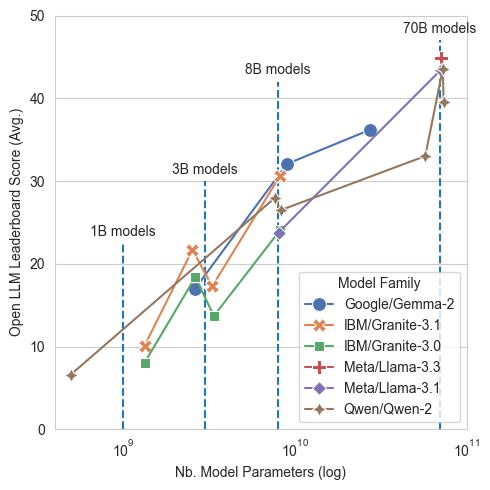

In [6]:
sns.set_style("whitegrid")
sns.despine(offset=10, trim=True)
plt.figure(figsize=(5, 5))

def add_marker_line_to_plt(txt: str, x, ymax, label: str = None):
    plt.text(x=x, y=ymax + 0.9, s=txt, horizontalalignment="center")
    plt.vlines(
        x=x,
        ymin=0,
        ymax=ymax,
        linestyles="dashed",
        label=label,
    )

add_marker_line_to_plt(txt="70B models", x=70_000_000_000, ymax=47)
add_marker_line_to_plt(txt="8B models", x=8_000_000_000, ymax=42)
add_marker_line_to_plt(txt="3B models", x=3_000_000_000, ymax=30)
add_marker_line_to_plt(txt="1B models", x=1_000_000_000, ymax=22.5)

ax = sns.lineplot(
    data=leaderboard_data,
    x="param_count_num",
    y="Average ⬆️",
    hue="family_name",
    style="family_name",
    palette="deep",  # You can choose a different color palette if you prefer
    # markers=["o", "s", "D", "^", "v"],  # Different markers for different model families
    # linestyles="-",
    markers=True,
    dashes=False,
    markersize=10,
    errorbar=None
)

ax.set_xlim([400_000_000, 100_000_000_000])
ax.set_ylim([0, 50])
ax.set_xscale("log")
ax.xaxis.grid(False)

# Customize the plot
plt.xlabel("Nb. Model Parameters (log)")
plt.ylabel("Open LLM Leaderboard Score (Avg.)")

# Add a legend with a title
plt.legend(title="Model Family")

# Display the plot
plt.tight_layout()

write_figure_to_disk(
    plt=plt,
    file_name="open_llm_leaderboard_results",
    chapter_name="00_introduction"
)
